Welcome the MCNN part of the project.

In this notebook we will go through the entire process of building a multi-column convolutional neural network.

Make sure that the ShanghaiTech dataset is installed and specify the working directory

Generating the density maps and training the model are very long tasks

In order to make the process faster we have uploaded the pretrained weights to the project

However we did not upload the density maps due to the heavy size of they occupy

We do have them on our end if you would like to have them without running the code and waiting for them to be generated do not hesistate to send us an email.

In [27]:
"""Specify the parent directory
do not change if you are working from within the MCNN file path"""

directory = '../'

In [1]:
#If you want to use the drive as an extension to the project please run this code
#we mount the drive in order to get access to the drive where we keep the dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#this is used to install the latest version of albumentations in order to transform the image and the keypoints at the same time

!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.5.2 is successfully installed


In [3]:
#import all the necessary libraries and set device to gpu

import scipy.io
from scipy.ndimage import gaussian_filter
from scipy import signal
import scipy
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.datasets as datasets
from matplotlib import cm as CM

import time 
from tqdm import tqdm_notebook as tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#check if gpu has been allocated

device

device(type='cpu')

In [4]:
#functions used to generate density map

#we give information about the image for which we want to find the filepath and output the transformed keypoints and image
def get_gt_mat(number, t_or_t, part):
  format_gt = directory + 'ShanghaiTech/part_' + part.upper() + \
            '/' + t_or_t.lower() + '_data/ground-truth/GT_IMG_' + str(number) \
            + '.mat'
  format_img = directory + 'ShanghaiTech/part_' + part.upper() + \
            '/' + t_or_t.lower() + '_data/images/IMG_' + str(number) \
            + '.jpg'
  mat = scipy.io.loadmat(format_gt)
  mat = mat['image_info'][0,0][0,0][0]
  img = cv2.imread(format_img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  aug = A.Compose([
      A.Resize(768, 1024),
      A.Normalize((0.5), (0.5)),
  ], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))
  rst = aug(image=img, keypoints=mat)
  img = rst['image']
  mat = rst['keypoints']
  mat = torch.tensor(mat)
  return mat, img.shape[0:2], img

#from the transformed data we generate the density map
def mat2img(mat, img_size, beta, k):
  mat = mat.to(device)
  img = torch.tensor(torch.zeros(img_size))
  img.to(device)
  for i in mat:
    dist = torch.cdist(i.view(1,2), mat)
    d = float(torch.sum(torch.topk(dist, k+1, largest=False).values))/float(k)
    first = int(torch.round(i[1]))
    second = int(torch.round(i[0]))
    if first >= img_size[0]: first = img_size[0]-1
    if second >= img_size[1]: second = img_size[1]-1
    img += gaussian_filter(signal.unit_impulse(img_size, (first, second)), beta*d)
  gt_heatmap = np.array(img) 
  return gt_heatmap

#for a given part of the dataset generate all the heatmaps
def gt2heatmap(part, t_or_t):
  if part.lower() == 'a':
    if t_or_t.lower() == 'train':
      number = 300
    elif t_or_t.lower() == 'test':
      number = 182
  elif part.lower() == 'b':
    if t_or_t.lower() == 'train':
      number = 400
    elif t_or_t.lower() == 'test':
      number = 316
  for i in range(1, number+1):
    if i % 10 == 0: print(i, '/', number)
    mat, size, _ = get_gt_mat(i, t_or_t, part)
    gt_heatmap = mat2img(mat, size, 0.3, 3)
    gt_heatmap = cv2.resize(gt_heatmap, (gt_heatmap.shape[1] // 4, gt_heatmap.shape[0] // 4))
    gt_heatmap *= 16
    format_gt = directory + 'MCNN/densitymap/part_' + part.upper() + \
            '/' + t_or_t.lower() + '_data/GT_H_' + str(i) \
            + '.npy'
    np.save(format_gt, gt_heatmap)

#generates all the heatmaps
def get_all_heatmap():
  part = ['a', 'b']
  t_or_t = ['train', 'test']
  for i in part:
    for j in t_or_t:
      print("part ", i, " ", j, " is starting!")
      gt2heatmap(i, j)
      print("part ", i, " ", j, " is done!")

In [6]:
#this generates all the heatmaps
### this is a very long operation and the heatmaps have already been computed and saved in the drive
get_all_heatmap()

part a train is starting
130 / 182


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


140 / 182
150 / 182
160 / 182
170 / 182
180 / 182
part a train is done!


In [10]:
#get the heatmap for a specific image in order to visualise result
number = 28
part = 'a'
t_or_t = 'test'
mat, size, img = get_gt_mat(number, t_or_t, part)
gt_heatmap = mat2img(mat, size, 0.3, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


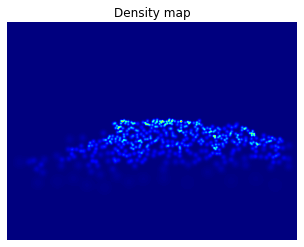

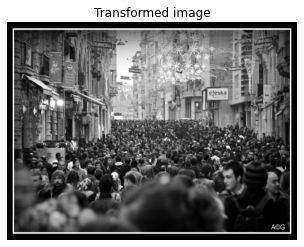

In [13]:
#print crowd density heatmap and associated image

plt.imshow(gt_heatmap, cmap=CM.jet)
plt.title('Density map')
plt.axis('off')
plt.show()

plt.imshow(img, cmap='gray')
plt.title('Transformed image')
plt.axis('off')
plt.show()



In [5]:
#define MCNN architecture

import torch.nn as nn

class MCNN(nn.Module):
  """
  This is the definition of the MCNN module
  we define three branches with different sized kernels
  the output varies depending on the the mode type:
    0 : MCNN
    1 : column1
    2 : column2
    3 : column3 
  """
  def __init__(self):
    super(MCNN, self).__init__()
    self.mode = 0   

    self.c1_layer_1 = nn.Conv2d(1, 16, 9, padding=4)
    self.c1_layer_2 = nn.Conv2d(16, 32, 7, padding=3)
    self.c1_layer_3 = nn.Conv2d(32, 16, 7, padding=3)
    self.c1_layer_4 = nn.Conv2d(16, 8, 7, padding=3)
    self.pool = nn.MaxPool2d(2, 2)
    self.c1_end = nn.Conv2d(8,1,1)

    self.c2_layer_1 = nn.Conv2d(1, 20, 7, padding=3)
    self.c2_layer_2 = nn.Conv2d(20, 40, 5, padding=2)
    self.c2_layer_3 = nn.Conv2d(40, 20, 5, padding=2)
    self.c2_layer_4 = nn.Conv2d(20, 10, 5, padding=2)
    self.c2_end = nn.Conv2d(10,1,1)

    self.c3_layer_1 = nn.Conv2d(1, 24, 5, padding=2)
    self.c3_layer_2 = nn.Conv2d(24, 48, 3, padding=1)
    self.c3_layer_3 = nn.Conv2d(48, 24, 3, padding=1)
    self.c3_layer_4 = nn.Conv2d(24, 12, 3, padding=1)
    self.c3_end = nn.Conv2d(12,1,1)

    self.mcnn_out = nn.Conv2d(30,1,1)

  def forward(self, x):
    size1 = x.size()[1]
    size2 = x.size()[2]
    h = x.view((-1, 1, size1, size2)).float()
    
    hc1 = torch.relu(self.c1_layer_1(h))
    hc1 = self.pool(hc1)
    hc1 = torch.relu(self.c1_layer_2(hc1))
    hc1 = self.pool(hc1)
    hc1 = torch.relu(self.c1_layer_3(hc1))
    hc1 = torch.relu(self.c1_layer_4(hc1))

    hc2 = torch.relu(self.c2_layer_1(h))
    hc2 = self.pool(hc2)
    hc2 = torch.relu(self.c2_layer_2(hc2))
    hc2 = self.pool(hc2)
    hc2 = torch.relu(self.c2_layer_3(hc2))
    hc2 = torch.relu(self.c2_layer_4(hc2))
  
    hc3 = torch.relu(self.c3_layer_1(h))
    hc3 = self.pool(hc3)
    hc3 = torch.relu(self.c3_layer_2(hc3))
    hc3 = self.pool(hc3)
    hc3 = torch.relu(self.c3_layer_3(hc3))
    hc3 = torch.relu(self.c3_layer_4(hc3))

    if self.mode == 0:
      out = torch.cat((hc1, hc2, hc3), 1)
      out = torch.relu(self.mcnn_out(out))
    elif self.mode == 1:
      out = torch.relu(self.c1_end(hc1))
    elif self.mode == 2:
      out = torch.relu(self.c2_end(hc2))
    elif self.mode == 3:
      out =  torch.relu(self.c3_end(hc3))
      
    return out.squeeze()

In [6]:
#define training procedure for MCNN

def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset=dataset,
                      batch_size=batch_size,
                      shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        epoch_average_acc = 0.0
        epoch_average_mae = 0.0
        for (images, labels) in train_loader:
          images, labels = images.to(device), labels.to(device)
          y_pre = model(images)
          loss = criterion(y_pre, labels.float())
          pred_sum = torch.round(y_pre.sum(dim=(1,2))).int()
          gt_sum = torch.round(labels.sum(dim=(1,2))).int()
          acc = (pred_sum == gt_sum).float().mean()
          mae = torch.abs(pred_sum - gt_sum).float().mean()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_average_loss += loss.item() * batch_size / len(dataset)
          epoch_average_acc += acc.item() * batch_size / len(dataset)
          epoch_average_mae += mae.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.4f}, MAE: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss, epoch_average_acc, epoch_average_mae))
    return train_error

In [7]:
#Create the necessary building blocks to build a dataset capable of being fed to the dataloader

aug = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
])

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        heatmap = np.load(fn.replace('ShanghaiTech', 'MCNN/densitymap').replace('images/IMG', 'GT_H').replace('.jpg', '.npy'))

        augval = self.aug(image = im)
        im = augval['image']
        
        im = torch.from_numpy(im).float()
        dm = torch.from_numpy(heatmap).float()
        
        return im, dm

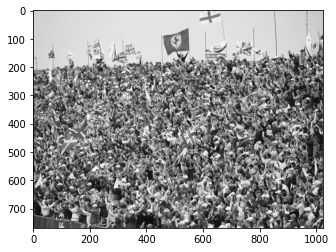

In [18]:
#create the dataset using the training images in part B
#the same code was used to create dataset for part A however the path was changed to take the correct input

t = [p.path for p in os.scandir(directory + 'ShanghaiTech/part_A/train_data/images/')]

t_train = t

ds_train = MyDataset(t_train, aug)
im, dm = ds_train[4]
plt.imshow(im, cmap='gray')

In [8]:
#define a function to find initialise the weights of the model

def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

In [ ]:
#initial training procdedure for the MCNN module
#Very long operation we already saved the trained weights to the drive

model = MCNN().to(device)
model.mode = 1
weights_normal_init(model, dev=0.01)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

num_epochs = 50
batch_size = 5

train_error = train(num_epochs, batch_size, criterion, optimizer, model, ds_train)

model.mode = 2
train_error = train(num_epochs, batch_size, criterion, optimizer, model, ds_train)

model.mode = 3
train_error = train(num_epochs, batch_size, criterion, optimizer, model, ds_train)

model.mode = 0
train_error = train(num_epochs, batch_size, criterion, optimizer, model, ds_train)

PATH = directory + 'MCNN/state/new.pt'
torch.save(model.state_dict(), PATH)

In [9]:
#Loading the pretrained weights

PATH = directory + 'MCNN/state/partB_final.pt'
model = MCNN()
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

MCNN(
  (c1_layer_1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (c1_layer_2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (c1_layer_3): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (c1_layer_4): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c1_end): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (c2_layer_1): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (c2_layer_2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2_layer_3): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2_layer_4): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2_end): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
  (c3_layer_1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c3_layer_2): Conv2d(24, 48, kernel_size=(3, 3), str

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.FloatTensor


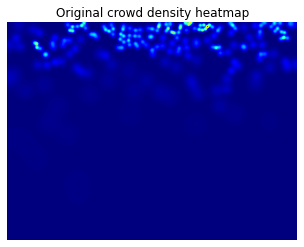

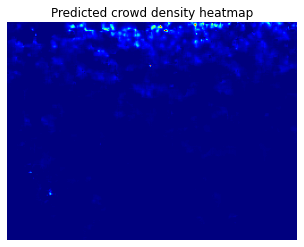

In [25]:
#test the output of the model by visualising it

model.eval()
model.to(device)

model.mode = 0

mat, size, img = get_gt_mat(6, 'test', 'b')
gt_heatmap = mat2img(mat, size, 0.3, 3)

input = torch.tensor(img).view(1, size[0], size[1]).to(device)
print(input.type())

output1 = model(input)
output1 = output1.cpu().detach().squeeze().numpy()

plt.imshow(gt_heatmap, cmap=CM.jet)
plt.title('Original crowd density heatmap')
plt.axis('off')
plt.show()

plt.imshow(output1, cmap=CM.jet)
plt.title('Predicted crowd density heatmap')
plt.axis('off')
plt.show()

In [26]:
#printing predicted number of people in the image versus actual number of people in the image

print("prediction   ", np.sum(output1))
print("actual value ", np.sum(gt_heatmap))


prediction    210.12282
actual value  194.99999999999997


After a first series of training where we perform a fixed number of epochs on all branches we save the model as an initial weight save

We then use this save to further train the model if we have to

There are two models that can be further trained: partA_initial and partB_initial

This training was further performed to generate the saved weights: partA_final, partB_final

In [ ]:
#retrain the model in order to get better results
#In this case we are only training the MCNN module and not the individual branches

PATH = directory + 'MCNN/state/partA_initial.pt'
model = MCNN()
model.load_state_dict(torch.load(PATH))
model.to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

num_epochs = 200
batch_size = 5

model.mode = 0
train_error = train(num_epochs, batch_size, criterion, optimizer, model, ds_train)

PATH = directory + 'MCNN/state/PartA.pt'
torch.save(model.state_dict(), PATH)

Epoch [1/200], Loss: 25.0446, Acc: 0.0125, MAE: 29.7250
Epoch [2/200], Loss: 23.3430, Acc: 0.0050, MAE: 29.2850
Epoch [3/200], Loss: 22.3833, Acc: 0.0150, MAE: 25.9800
Epoch [4/200], Loss: 22.2218, Acc: 0.0100, MAE: 26.4050
Epoch [5/200], Loss: 22.3752, Acc: 0.0075, MAE: 27.4825
Epoch [6/200], Loss: 22.1669, Acc: 0.0150, MAE: 27.3500
Epoch [7/200], Loss: 22.1698, Acc: 0.0125, MAE: 25.7925
Epoch [8/200], Loss: 23.0583, Acc: 0.0100, MAE: 32.2975
Epoch [9/200], Loss: 23.0558, Acc: 0.0075, MAE: 30.5000
Epoch [10/200], Loss: 22.2219, Acc: 0.0225, MAE: 27.1825
Epoch [11/200], Loss: 21.8218, Acc: 0.0050, MAE: 26.7650
Epoch [12/200], Loss: 21.1978, Acc: 0.0125, MAE: 25.4825
Epoch [13/200], Loss: 23.0836, Acc: 0.0075, MAE: 31.1050
Epoch [14/200], Loss: 21.5250, Acc: 0.0075, MAE: 26.4100
Epoch [15/200], Loss: 22.4312, Acc: 0.0125, MAE: 29.0600
Epoch [16/200], Loss: 21.2306, Acc: 0.0175, MAE: 27.6575
Epoch [17/200], Loss: 20.8510, Acc: 0.0075, MAE: 25.9000
Epoch [18/200], Loss: 22.7971, Acc: 0.01

In [10]:
#define evalution function to test the mean absolute arror and mean squared error

def evaluate(dataset, model, criterion, batch_size):
  mse_eval = 0
  mae_eval = 0
  dataloader = DataLoader(dataset, batch_size = batch_size)
  for (img, labels) in dataloader:
    img, labels = img.to(device), labels.to(device)
    y_pre = model(img)
    loss = criterion(y_pre, labels.float())
    try:
      pred_sum = torch.round(y_pre.sum(dim=(1,2))).int()
      gt_sum = torch.round(labels.sum(dim=(1,2))).int()
    except IndexError:
      pred_sum = torch.round(y_pre.sum()).int()
      gt_sum = torch.round(labels.sum()).int()
    mae = torch.abs(pred_sum - gt_sum).float().mean()
    mse_eval += loss.item() * batch_size / len(dataset)
    mae_eval += mae.item() * batch_size / len(dataset)
  return mae_eval, mse_eval


In [11]:
#create a test and validation dataset

from sklearn.model_selection import train_test_split

batch_size = 5
criterion = nn.MSELoss(reduction='sum')
t_eval = [p.path for p in os.scandir(directory + 'ShanghaiTech/part_B/test_data/images/')]
t_val, t_test = train_test_split(t_eval, test_size = 0.5, random_state = 42)

ds_val = MyDataset(t_eval, aug)
ds_test = MyDataset(t_test, aug)

In [12]:
#evaluate the model on the validation set and retrain if necessary
PATH = directory + 'MCNN/state/partB_final.pt'
model = MCNN()
model.load_state_dict(torch.load(PATH, map_location=device))
model.to(device)

model.eval()

model.to(device)

model.mode = 0

mae_val, mse_val = evaluate(ds_val, model, criterion, batch_size)
print("mae val ", mae_val)
print("mse val ", mse_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 192, 256])) that is different to the input size (torch.Size([192, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


mae val  22.6455697153188
mse val  41.41893633936027


In [35]:
#final evaluation of the model on the test set

model.eval()

model.to(device)

model.mode = 0

mae_test, mse_test = evaluate(ds_test, model, criterion, batch_size)
print("mae test ", mae_test)
print("mse test ", mse_test)

mae test  23.810126479667957
mse test  42.481426838078086


In [16]:
#testing model on the test set of part A

t_test_a = [p.path for p in os.scandir(directory + 'ShanghaiTech/part_A/test_data/images/')]
batch_size = 5
criterion = nn.MSELoss(reduction='sum')

ds_test_a = MyDataset(t_test_a, aug)

model.eval()

model.to(device)

model.mode = 0

mae_test, mse_test = evaluate(ds_test_a, model, criterion, batch_size)
print("mae test ", mae_test)
print("mse test ", mse_test)

mae test  174.89011198609737
mse test  215.82935882138676


In [19]:
from sklearn.model_selection import train_test_split

PATH = directory + 'MCNN/state/partA_final.pt'
model = MCNN()
model.load_state_dict(torch.load(PATH, map_location=device))
model.to(device)

batch_size = 5
criterion = nn.MSELoss(reduction='sum')
t_eval = [p.path for p in os.scandir(directory + 'ShanghaiTech/part_A/test_data/images/')]
t_val, t_test = train_test_split(t_eval, test_size = 0.5, random_state = 42)

ds_valA = MyDataset(t_eval, aug)
ds_testA = MyDataset(t_test, aug)

#evaluate the model on the validation set and retrain if necessary

model.eval()

model.to(device)

model.mode = 0

mae_val, mse_val = evaluate(ds_valA, model, criterion, batch_size)
print("mae val ", mae_val)
print("mse val ", mse_val)

mae val  149.230769440368
mse val  175.35544276237493


In [20]:
#final evaluation of the model on the test set

model.eval()

model.to(device)

model.mode = 0

mae_test, mse_test = evaluate(ds_testA, model, criterion, batch_size)
print("mae test ", mae_test)
print("mse test ", mse_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 192, 256])) that is different to the input size (torch.Size([192, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


mae test  127.0549445099883
mse test  159.9434267950582
